Parameters:
{   'anomaly': {   'likelihood': {   'probationaryPct': 0.1,
                                     'reestimationPeriod': 100}},
    'enc': {   'time': {'timeOfDay': (30, 1), 'weekend': 21},
               'value': {'resolution': 0.88, 'size': 700, 'sparsity': 0.02}},
    'predictor': {'sdrc_alpha': 0.1},
    'sp': {   'boostStrength': 3.0,
              'columnCount': 1638,
              'localAreaDensity': 0.04395604395604396,
              'potentialPct': 0.85,
              'synPermActiveInc': 0.04,
              'synPermConnected': 0.13999999999999999,
              'synPermInactiveDec': 0.006},
    'tm': {   'activationThreshold': 17,
              'cellsPerColumn': 13,
              'initialPerm': 0.21,
              'maxSegmentsPerCell': 128,
              'maxSynapsesPerSegment': 64,
              'minThreshold': 10,
              'newSynapseCount': 32,
              'permanenceDec': 0.1,
              'permanenceInc': 0.1}}

Encoded Input SDR( 1462 )
    Sparsity Mi

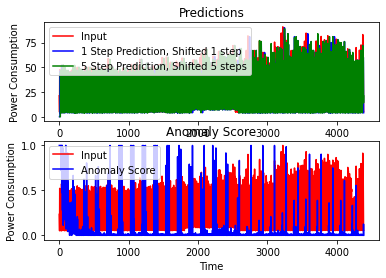

In [2]:
import csv
import datetime
import os
import numpy as np
import random
import math

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood 
#FIXME 代わりにTM.anomalyを使用しますが、 py.AnomalyLikelihoodよりも悪い結果になります
from htm.bindings.algorithms import Predictor

_INPUT_FILE_PATH ="gymdata.csv"

default_parameters = {
  # 2 つの（3 つの）エンコーダがあります: "value" (RDSE) & "time" (DateTime weekend, timeOfDay)
 'enc': {
      "value" :
         {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
      "time": 
         {'timeOfDay': (30, 1), 'weekend': 21}
 },
 'predictor': {'sdrc_alpha': 0.1},
 'sp': {'boostStrength': 3.0,
        'columnCount': 1638,
        'localAreaDensity': 0.04395604395604396,
        'potentialPct': 0.85,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'synPermInactiveDec': 0.006},
 'tm': {'activationThreshold': 17,
        'cellsPerColumn': 13,
        'initialPerm': 0.21,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'minThreshold': 10,
        'newSynapseCount': 32,
        'permanenceDec': 0.1,
        'permanenceInc': 0.1},
 'anomaly': {
   'likelihood': 
       {#'learningPeriod': int(math.floor(self.probationaryPeriod / 2.0)),
        #'probationaryPeriod': self.probationaryPeriod-default_parameters["anomaly"]["likelihood"]["learningPeriod"],
        'probationaryPct': 0.1,
        'reestimationPeriod': 100} #これらの設定は、NABからコピーされます
 }
}

def main(parameters=default_parameters, argv=None, verbose=True):
  if verbose:
    import pprint
    print("Parameters:")
    pprint.pprint(parameters, indent=4)
    print("")

  # 入力ファイルの読み込み.
  records = []
  with open(_INPUT_FILE_PATH, "r") as fin:
    reader = csv.reader(fin)
    headers = next(reader)
    next(reader)
    next(reader)
    for record in reader:
      records.append(record)

  # エンコーダーを作成します。 これらは入力データをバイナリ表現に変換します.
  dateEncoder = DateEncoder(timeOfDay= parameters["enc"]["time"]["timeOfDay"], 
                            weekend  = parameters["enc"]["time"]["weekend"]) 
  
  scalarEncoderParams            = RDSE_Parameters()
  scalarEncoderParams.size       = parameters["enc"]["value"]["size"]
  scalarEncoderParams.sparsity   = parameters["enc"]["value"]["sparsity"]
  scalarEncoderParams.resolution = parameters["enc"]["value"]["resolution"]
  scalarEncoder = RDSE( scalarEncoderParams )
  encodingWidth = (dateEncoder.size + scalarEncoder.size)
  enc_info = Metrics( [encodingWidth], 999999999 )

  # HTMを作る。 SpatialPoolerとTemporalMemoryと関連ツール.
  spParams = parameters["sp"]
  sp = SpatialPooler(
    inputDimensions            = (encodingWidth,),
    columnDimensions           = (spParams["columnCount"],),
    potentialPct               = spParams["potentialPct"],
    potentialRadius            = encodingWidth,
    globalInhibition           = True,
    localAreaDensity           = spParams["localAreaDensity"],
    synPermInactiveDec         = spParams["synPermInactiveDec"],
    synPermActiveInc           = spParams["synPermActiveInc"],
    synPermConnected           = spParams["synPermConnected"],
    boostStrength              = spParams["boostStrength"],
    wrapAround                 = True
  )
  sp_info = Metrics( sp.getColumnDimensions(), 999999999 )

  tmParams = parameters["tm"]
  tm = TemporalMemory(
    columnDimensions          = (spParams["columnCount"],),
    cellsPerColumn            = tmParams["cellsPerColumn"],
    activationThreshold       = tmParams["activationThreshold"],
    initialPermanence         = tmParams["initialPerm"],
    connectedPermanence       = spParams["synPermConnected"],
    minThreshold              = tmParams["minThreshold"],
    maxNewSynapseCount        = tmParams["newSynapseCount"],
    permanenceIncrement       = tmParams["permanenceInc"],
    permanenceDecrement       = tmParams["permanenceDec"],
    predictedSegmentDecrement = 0.0,
    maxSegmentsPerCell        = tmParams["maxSegmentsPerCell"],
    maxSynapsesPerSegment     = tmParams["maxSynapsesPerSegment"]
  )
  tm_info = Metrics( [tm.numberOfCells()], 999999999 )

  # セットアップ尤度（ゆうど）は、これらの設定が NAB
  anParams = parameters["anomaly"]["likelihood"]
  probationaryPeriod = int(math.floor(float(anParams["probationaryPct"])*len(records)))
  learningPeriod     = int(math.floor(probationaryPeriod / 2.0))
  anomaly_history = AnomalyLikelihood(learningPeriod= learningPeriod,
                                      estimationSamples= probationaryPeriod - learningPeriod,
                                      reestimationPeriod= anParams["reestimationPeriod"])

  predictor = Predictor( steps=[1, 5], alpha=parameters["predictor"]['sdrc_alpha'] )
  predictor_resolution = 1

  # データセット内のすべてのデータを反復処理し、入力と出力を記録します.
  inputs      = []
  anomaly     = []
  anomalyProb = []
  predictions = {1: [], 5: []}
  for count, record in enumerate(records):

    # 日付文字列をPythonの日付オブジェクトに変換する.
    dateString = datetime.datetime.strptime(record[0], "%m/%d/%y %H:%M")
    # データ値の文字列をfloatに変換.
    consumption = float(record[1])
    inputs.append( consumption )

    # エンコーダを呼び出して、各値のビット表現を作成します。 これらは SDR オブジェクトです.
    dateBits        = dateEncoder.encode(dateString)
    consumptionBits = scalarEncoder.encode(consumption)

    # これらのすべてのエンコーディングを 1 つの大きなエンコーディングに連結して、
    # 空間プーリング用に使用します.
    encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
    enc_info.addData( encoding )

    # これは、以下の計算方法で作成されます
    # Spatial Poolerと同じ寸法でなければなりません
    activeColumns = SDR( sp.getColumnDimensions() )

    # 入力空間に対する空間プーリングアルゴリズムの実行.
    sp.compute(encoding, True, activeColumns)
    sp_info.addData( activeColumns )

    # アクティブなミニカラムに対してTemporal Memoryアルゴリズムを実行する.
    tm.compute(activeColumns, learn=True)
    tm_info.addData( tm.getActiveCells().flatten() )

    # 何が起こるかを予測し、今起こったことに基づいて予測器を訓練する.
    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1, 5):
      if pdf[n]:
        predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
      else:
        predictions[n].append(float('nan'))

    anomalyLikelihood = anomaly_history.anomalyProbability( consumption, tm.anomaly )
    anomaly.append( tm.anomaly )
    anomalyProb.append( anomalyLikelihood )

    predictor.learn(count, tm.getActiveCells(), int(consumption / predictor_resolution))


  # HTMの状態に関する情報と統計を印刷する.
  print("Encoded Input", enc_info)
  print("")
  print("Spatial Pooler Mini-Columns", sp_info)
  print(str(sp))
  print("")
  print("Temporal Memory Cells", tm_info)
  print(str(tm))
  print("")

  # 予測した入力と一致するように予測値をシフトする.
  for n_steps, pred_list in predictions.items():
    for x in range(n_steps):
        pred_list.insert(0, float('nan'))
        pred_list.pop()

  # 予測精度、Root-Mean-Squaredを計算します
  accuracy         = {1: 0, 5: 0}
  accuracy_samples = {1: 0, 5: 0}

  for idx, inp in enumerate(inputs):
    for n in predictions: # 予測された各[N]ステップ先の時間ステップ数について.
      val = predictions[n][ idx ]
      if not math.isnan(val):
        accuracy[n] += (inp - val) ** 2
        accuracy_samples[n] += 1
  for n in sorted(predictions):
    accuracy[n] = (accuracy[n] / accuracy_samples[n]) ** .5
    print("Predictive Error (RMS)", n, "steps ahead:", accuracy[n])

  # 異常値（平均値と標準値）についての情報を表示する
  print("Anomaly Mean", np.mean(anomaly))
  print("Anomaly Std ", np.std(anomaly))

  # 予測と異常値をプロットします
  if verbose:
    try:
      import matplotlib.pyplot as plt
      %matplotlib inline
    except:
      print("WARNING: failed to import matplotlib, plots cannot be shown.")
      return -accuracy[5]

    plt.subplot(2,1,1)
    plt.title("Predictions")
    plt.xlabel("Time")
    plt.ylabel("Power Consumption")
    plt.plot(np.arange(len(inputs)), inputs, 'red',
             np.arange(len(inputs)), predictions[1], 'blue',
             np.arange(len(inputs)), predictions[5], 'green',)
    plt.legend(labels=('Input', '1 Step Prediction, Shifted 1 step', '5 Step Prediction, Shifted 5 steps'))

    plt.subplot(2,1,2)
    plt.title("Anomaly Score")
    plt.xlabel("Time")
    plt.ylabel("Power Consumption")
    inputs = np.array(inputs) / max(inputs)
    plt.plot(np.arange(len(inputs)), inputs, 'red',
             np.arange(len(inputs)), anomaly, 'blue',)
    plt.legend(labels=('Input', 'Anomaly Score'))
    plt.show()

  return -accuracy[5]


if __name__ == "__main__":
  main()